## ewf-wfp-02-01-04 - Land Surface Temperature Anomalies Time Series

Land Surface Temperature Anomalies Time Series

---

### <a name="service">Service definition

In [1]:
service = dict([('title', 'Land Surface Temperature Anomalies Time Series'),
                ('abstract', 'Land Surface Temperature Anomalies Time Series'),
                ('id', 'ewf-wfp-02-01-04')])

### <a name="parameter">Parameter Definition 

In [2]:
N_1 = dict([('id', 'N_1'),
                          ('value', 'False'),
                          ('title', 'No Aggregation'),
                          ('abstract', 'No aggregation')])

In [3]:
N_3 = dict([('id', 'N_3'),
                          ('value', 'True'),
                          ('title', '30 Day Aggregation'),
                          ('abstract', 'Get a 30 day aggregation')])

In [4]:
N_6 = dict([('id', 'N_6'),
                          ('value', 'False'),
                          ('title', '60 Day Aggregation'),
                          ('abstract', 'Get a 30 day aggregation')])

In [5]:
 N_9 = dict([('id', 'N_9'),
                          ('value', 'False'),
                          ('title', '90 Day Aggregation'),
                          ('abstract', 'Get a 90 day aggregation')])

In [6]:
 N_12 = dict([('id', 'N_12'),
                          ('value', 'False'),
                          ('title', '120 Day Aggregation'),
                          ('abstract', 'Get a 120 day aggregation')])

In [7]:
 N_15 = dict([('id', 'N_15'),
                          ('value', 'False'),
                          ('title', '150 Day Aggregation'),
                          ('abstract', 'Get a 150 day aggregation')])

In [8]:
 N_18 = dict([('id', 'N_18'),
                          ('value', 'False'),
                          ('title', '180 Day Aggregation'),
                          ('abstract', 'Get a 180 day aggregation')])

In [9]:
 N_27 = dict([('id', 'N_27'),
                          ('value', 'False'),
                          ('title', '270 Day Aggregation'),
                          ('abstract', 'Get a 270 day aggregation')])

In [10]:
 N_36 = dict([('id', 'N_36'),
                          ('value', 'False'),
                          ('title', '360 Day Aggregation'),
                          ('abstract', 'Get a 360 day aggregation')])

In [11]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                         ('value', 'POLYGON((11.5030755518998 -11.1141633706909,41.0343255518998 -11.1141633706909,41.0343255518998 -34.9763656693858,11.5030755518998 -34.9763656693858,11.5030755518998 -11.1141633706909))'),
                         ('title', 'WKT Polygon for the Region of Interest'),
                         ('abstract', 'Set the value of WKT Polygon')])

In [12]:
nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', 'SouthernAfrica'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

In [13]:
indexAndApiKeys = dict([('id', 'indexAndApiKeys'),
                        ('value', ''),
                        ('title', 'index,apikey pairs'),
                        ('abstract', 'index,apikey pairs'),
                        ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the MDOIS stack of products' identifiers

In [14]:
input_identifiers = ('B02BEB4BAA63351C44F3DF2C9A6D8D116D089325', '442355F3238A8B5B9A016D3929ED42FCCF13C236')

**Input references**

This is the MODIS stack catalogue references

In [15]:
input_references = ('https://catalog.terradue.com/better-wfp-02-01-02/search?format=atom&uid=B02BEB4BAA63351C44F3DF2C9A6D8D116D089325', 'https://catalog.terradue.com/better-wfp-02-01-03/search?format=atom&uid=442355F3238A8B5B9A016D3929ED42FCCF13C236')

**Data path**

This path defines where the data is staged-in. 

In [16]:
data_path = "/workspace/modis/outputs/output_02_03"

#### Aux folders

In [17]:
output_folder = ''

In [18]:
temp_folder = 'temp'

#### Import Modules

In [19]:
import os
import shutil

import cioppy

import sys
import string
import numpy as np
from osgeo import gdal, ogr, osr
from shapely.wkt import loads

import pdb

import pandas as pd
import geopandas as gpd

import datetime

ciop = cioppy.Cioppy()

#### Auxiliary vars

In [20]:
check_results = False

#### Auxiliary methods

In [21]:
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e) 
    
    
# get metadata from catalog
def get_input_metadata (input_refs, apikeys):
    
    # for each product get metadata
    Result_Prod = []
    
    for index,product_ref in enumerate(input_refs):
        
        for index in apikeys:
            if index in product_ref:
                cat_index = index
                cat_apikey = apikeys[index]
        
        # since the search is by identifier
        Result_Prod.append(ciop.search(end_point = product_ref,params =[],output_fields='self,identifier,startdate,enclosure,startdate,enddate,wkt,title',creds='{}:{}'.format(cat_index,cat_apikey))[0] )
    

    input_metadata = gpd.GeoDataFrame.from_dict(Result_Prod)

    input_metadata['startdate'] = pd.to_datetime(input_metadata['startdate'])
    input_metadata['enddate'] = pd.to_datetime(input_metadata['enddate'])
    
    return input_metadata


   
    
def get_metadata(filepath):
        
    #pdb.set_trace()
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type


def get_matrix_list(image_list):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        mat_list.append(product_array)
        dataset = None
        
        print(type(product_array))
    return mat_list


def calc_anomaly(agg_file, LTA_file):
    
    
    #file_list = []
    #if not os.path.isdir('tmp_data'):
    #    os.mkdir('tmp_data')
    #for enclosure in dataframe['enclosure'].tolist():
    #    filepath = 'tmp_data/' + os.path.basename(enclosure)
    #    status = get_product(enclosure, filepath)
    #    if status == 200:
    #        file_list.append(filepath)
    #print(file_list)
    
    
    
    if agg_file and LTA_file:
        
        
        agg_and_LTA = get_matrix_list([agg_file, LTA_file])
        print('Aggregation and LTA converted to matrices')
        
        print(agg_and_LTA[0].dtype)
        print(agg_and_LTA[1].dtype)
        
        #anomaly_values = np.divide(agg_and_LTA[0] * 1.0, agg_and_LTA[1] * 1.0)
        
        anomaly_values = np.divide(agg_and_LTA[0] * 1.0, agg_and_LTA[1] * 1.0, out=np.zeros_like(agg_and_LTA[0] * 1.0), where=agg_and_LTA[1]!=0)
        
        #anomaly_values[(agg_and_LTA[0] == 0)] = 0
        #anomaly_values[(agg_and_LTA[1] == 0)] = 0
        
        print(anomaly_values.dtype)
        
        projection, geotransform, no_data_value, data_type = get_metadata(agg_file)
        
        
        
        #for file_ in file_list:
        #    os.remove(file_)
        
        return anomaly_values, projection, geotransform, no_data_value, data_type
    
    else:
        return None, None, None


def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    if mask is not None and mask is not 0:
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)

    

def write_anomaly_output(anomaly, output_folder, product_name, first_date, last_date, lta_start_year, lta_end_year, aggregation, mask_no_value, N_value, regionOfInterest, roi_name, projection, geo_transform, no_data_value):
    #image_number = (datetime.strptime(last_date, '%Y-%m-%d') - datetime.strptime(first_date, '%Y-%m-%d')).days
    
    
    #filename =  output_folder + '/' + product_name + '_Anomaly_' + roi_name + '_N' + str(N_value) + '_' + aggregation + '_' + first_date + '_' + last_date + '_LTA' + str(lta_start_year) + '_' + str(lta_end_year) + '.tif'
    
    filename = os.path.join(output_folder, product_name + '_Anomaly_' + roi_name + '_N' + str(N_value) + '_' + aggregation + '_' + first_date + '_' + last_date + '_LTA' + str(lta_start_year) + '_' + str(lta_end_year) + '.tif')
    
    write_output_image(filename, anomaly, 'GTiff', gdal.GDT_Float32, mask_no_value, projection, geo_transform, no_data_value)
    
    return filename



def get_formatted_date(date_str):
    date = datetime.datetime.strftime(date_str, '%Y-%m-%dT00:00:00Z')
    return date


def write_properties_file(output_name, first_date, last_date, region_of_interest):
    
    title = 'Output %s' % output_name
    
    first_date = get_formatted_date(first_date)
    last_date = get_formatted_date(last_date)
    
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date, last_date))
        file.write('geometry=%s' % (region_of_interest))

#### Auxiliary folders

In [22]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

#### Workflow

In [23]:
message = 'Getting metadata from catalog' 
ciop.log('INFO', message)


# organize indexes and apikeys in a python dictionary
indexAndApiKeys_splited = indexAndApiKeys['value'].split(',')
apikeys = {}
for idx,ele in enumerate(indexAndApiKeys_splited):
    
    if (idx % 2 == 0):
        print(ele)
        apikeys[ele] = indexAndApiKeys_splited[idx+1]
        

# get input data from catalog
input_metadata = get_input_metadata (input_references, apikeys)



input_metadata_LTA = input_metadata[input_metadata['title'].str.find('LTA') != -1]
input_metadata_Agg = input_metadata[input_metadata['title'].str.find('LTA') == -1]



reporter:status:2019-09-25T15:42:24.815312 [INFO   ] [user process] Getting metadata from catalog
2019-09-25T15:42:24.815312 [INFO   ] [user process] Getting metadata from catalog


better-wfp-02-01-02
better-wfp-02-01-03


In [24]:
#print('hello')
#pdb.set_trace()
if isinstance(input_identifiers, str):
    input_identifiers = [input_identifiers]

region_of_interest = regionOfInterest['value']
name_of_region = nameOfRegion['value']


# get data paths from catalog metadata

filepath_agg = os.path.join(data_path, input_metadata_Agg['enclosure'].iloc[0].split('/')[-1])
filepath_LTA = os.path.join(data_path, input_metadata_LTA['enclosure'].iloc[0].split('/')[-1])


print(filepath_agg)
print(filepath_LTA)


# N time steps
nlist = [N_1['value'], N_3['value'], N_6['value']]
nlist = [n == 'True' for n in nlist]
nvalues = [1, 3, 6]


# get metadata from catalog metadata (Agg and LTA)

# Agg

file_name_elements = os.path.basename(filepath_agg).split('.')[0].split('_')
#['LST', 'SouthernAfrica', 'N3', 'averages', '2015-01-01', '2015-01-21']
#first_date = file_name_elements[-2]
#last_date = file_name_elements[-1]
agg_type = file_name_elements[-3]
Nn = file_name_elements[-4]

first_date = input_metadata_Agg['startdate'].iloc[0].strftime('%Y-%m-%d')
last_date = input_metadata_Agg['enddate'].iloc[0].strftime('%Y-%m-%d')

print(first_date)
print(last_date)

# LTA

file_name_elements = os.path.basename(filepath_LTA).split('.')[0].split('_')
#['LTA', 'LST', 'SouthernAfrica', 'N3', 'averages', '1-1', '1-21', '2015', '2017']

#start_year = file_name_elements[-2]
#end_year = file_name_elements[-1]

agg_type_LTA = file_name_elements[-5]
Nn_LTA = file_name_elements[-6]


start_year = str(input_metadata_LTA['startdate'].iloc[0].year)
end_year = str(input_metadata_LTA['enddate'].iloc[0].year)

print(start_year)
print(end_year)



for bl,nv in zip(nlist, nvalues):
    
    # only works for selected N time steps
    if bl:        

       
            print(filepath_agg)
            print(filepath_LTA)
        
            message = 'Computing Anomaly' 
            ciop.log('INFO', message)
            
            anomaly_values, projection, geotransform, no_data_value, data_type = calc_anomaly(filepath_agg, filepath_LTA)
        
            
            
            message = 'Writing anomaly image' 
            ciop.log('INFO', message)
            
            filename = write_anomaly_output(anomaly_values, output_folder, 'LST', first_date, last_date, start_year, end_year, agg_type, None, nv, region_of_interest, name_of_region, projection, geotransform, no_data_value)
            
            
            write_properties_file(filename, datetime.datetime.strptime(first_date, "%Y-%m-%d").date(), datetime.datetime.strptime(last_date, "%Y-%m-%d").date(), region_of_interest)
            




/workspace/modis/outputs/output_02_03/LST_SouthernAfrica_N3_averages_2015-01-05_2015-01-25.tif
/workspace/modis/outputs/output_02_03/LTA_LST_SouthernAfrica_N3_averages_1-5_1-25_2015_2017.tif
2015-01-05
2015-01-25
2015
2017
/workspace/modis/outputs/output_02_03/LST_SouthernAfrica_N3_averages_2015-01-05_2015-01-25.tif
/workspace/modis/outputs/output_02_03/LTA_LST_SouthernAfrica_N3_averages_1-5_1-25_2015_2017.tif
<type 'numpy.ndarray'>


reporter:status:2019-09-25T15:42:31.901914 [INFO   ] [user process] Computing Anomaly
2019-09-25T15:42:31.901914 [INFO   ] [user process] Computing Anomaly


<type 'numpy.ndarray'>
Aggregation and LTA converted to matrices
uint16
uint16
float64


reporter:status:2019-09-25T15:42:32.195371 [INFO   ] [user process] Writing anomaly image
2019-09-25T15:42:32.195371 [INFO   ] [user process] Writing anomaly image


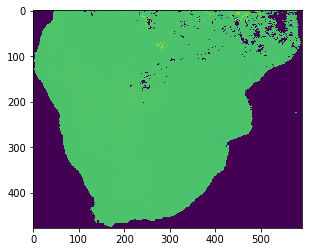

In [26]:
if check_results:

    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(anomaly_values)
    plt.show()

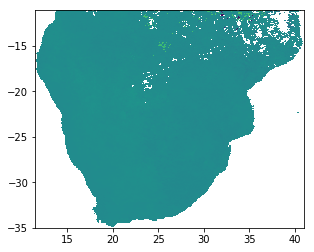

In [27]:
if check_results:

    import rasterio

    from rasterio.plot import show

    # Load data
    #raster = output_folder + '/' + 'LST_Anomaly_SouthernAfrica_N3_averages_2015-01-01_2015-01-21_LTA2015_2017.tif'
    raster = filename
    data = rasterio.open(raster)

    show(data)

    #data = georasters.from_file(raster)

    # Plot data
    #data.plot()

#### Remove temporay files and folders

In [28]:
rm_cfolder(temp_folder)

os.rmdir(temp_folder)